In [382]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import f1_score
from pprint import pprint
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import metrics
from collections import Counter
from sklearn import svm

In [17]:
# load in data from dat_processing
fire_data = pd.read_csv('Fire_regions_w_r')

In [59]:
# getting a list of months
month= []
for i in range(len(fire_data)):
    month.append(int(fire_data.ALARM_DATE[i][5:7]))

In [407]:
# getting list of windspeed
wind_spe = []
u10 = fire_data.u10.tolist()
v10 = fire_data.v10.tolist()
for i in range(len(fire_data)):
     wind_spe.append(np.sqrt(u10[i]**2 + v10[i]**2))

In [408]:
# adding months to df
fire_data['Month'] = month

In [409]:
# introducing smote fro class imbalance
sm = SMOTE(random_state = 42)

In [410]:
# cretaing x,y variables to put into model
x = fire_data.iloc[:, 8:10]
x['Month'] = month
x['Wind_Spe'] = wind_spe
x['Eco'] = fire_data.Eco_Region.tolist()
#x['u10'] = fire_data.u10.tolist()
#x['v10'] = fire_data.v10.tolist()
#x['Lat'] = fire_data.lat.tolist()
x['Long'] = fire_data.long.tolist()
y = fire_data.Classes

In [412]:
# creates tarining set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [413]:
# uses smote to oversample
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [434]:
def accu_by_class(model):
    """
    This breaks down the model accuracies into accuracies for each class
    
    """
    predicted_exp = model.predict(x_test)

    accu = []
    correct2 = []

        #loops through all classes to index each seperately and compare to predicited values
    for v in [0,1,2,3]:
        ind = []
        num = 0
            #loops through y_test to create index of where facial expression occurs in y_test
        for count, i in enumerate(y_test):
            if i == v:
                num += 1
                ind.append(count)

            # loops through predicted x_test classes and creates index
        ind1 = []
        num1 = 0
        for count, i in enumerate(predicted_exp):
            if i == v:
                num1 += 1
                ind1.append(count)

            # checks to see how many of the predicted indexes are correct
        correct = 0
        for i in ind1:
            if i in ind:
                correct +=1

            #appends number correct and accuracy percentage for each class
        correct2.append(correct)
        accu.append(correct/num)
        
    return accu

## Random Forest

In [414]:
# creates random forest model
rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42, min_samples_split= 2)
results = rfc.fit(x_train_res, y_train_res)

In [209]:
# model_params = {
#     'n_estimators': [250],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [2, 4, 6],
#     'max_features': ['sqrt','log2']}

# clf = GridSearchCV(rfc, model_params, cv=5)
# model = clf.fit(x, y)
# from pprint import pprint
# pprint(model.best_estimator_.get_params())

In [436]:
# prints accuracy and accuracy by class
print(accuracy_score(results.predict(x_test), y_test))
print(accu_by_class(results))

0.4803105934553522
[0.630308076602831, 0.20430107526881722, 0.15348837209302327, 0.17592592592592593]


## XGBOOST

In [424]:
# xgboost model
boost = XGBClassifier(max_depth=15, colsample_bytree =1, min_child_weight = .2 ,gamma =0, max_delta_step = 1,  
                      learning_rate=.05, n_estimators=10000, verbose = 1 , objective='multi:softprob')
        
eval_set = [(x_train_res,y_train_res),(x_test,y_test)] 
results_xg = boost.fit(x_train_res, y_train_res, eval_set = eval_set, verbose=True, early_stopping_rounds=150)

[10:43:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.16951	validation_1-merror:0.60455
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[1]	validation_0-merror:0.15275	validation_1-merror:0.63783
[2]	validation_0-merror:0.13389	validation_1-merror:0.62784
[3]	validation_0-merror:0.12883	validation_1-merror:0.62673
[4]	validation_0-merror:0.12040	validation_1-merror:0.62396
[5]	validation_0-merror:0.11560	validation_1-merror:0.61841
[6]	validation_0-merror:0.11018	validation_1-merror:0.62507
[7]	validation_0-merror:0.10476	validation_1-merror:0.62008

In [435]:
print(accuracy_score(results_xg.predict(x_test), y_test))
print(accu_by_class(results_xg))

0.4875207986688852


NameError: name 'accuracy_by_class' is not defined

## Support Vector Machine

In [390]:
lin_svm = svm.NuSVC(random_state = 42, verbose = 1)#, probability = True)
results_svm = lin_svm.fit(x_train_res,y_train_res)
accuracy = accuracy_score(results_svm.predict(x_test), y_test)

[LibSVM]

In [391]:
print(accuracy_score(results_xg.predict(x_test), y_test))
print(accu_by_class(results_svm))

0.5402107598447032

## XGBOOST accuracy by class plot

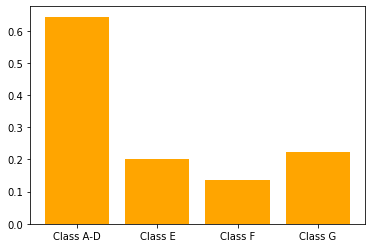

In [370]:
plt.bar(['Class A-D','Class E', 'Class F', "Class G"],accu, color = 'Orange')
plt.savefig('Accuray_per_class',dpi = 300, transparent = True)

In [265]:
y_test.reset_index(inplace= True, drop = True)

## XGBOOST feature importance plot

In [270]:
imp = results_xg.feature_importances_

In [329]:
sorted(imp)

[0.13634087, 0.15995002, 0.16016737, 0.17139214, 0.17508388, 0.19706571]

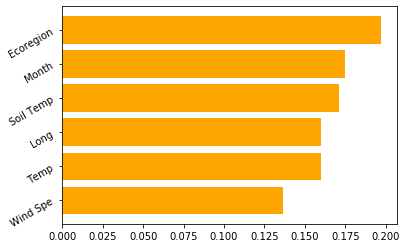

In [433]:
plt.barh(['Wind Spe','Temp', 'Long', "Soil Temp", 'Month','Ecoregion'],sorted(imp), color = 'Orange')
plt.yticks(rotation=30)
plt.savefig('feature_importance',dpi = 300, transparent = True, bbox_inches='tight')